# 1. Import
## 1.1. Import Library

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

## 1.2. Import Dataset

In [2]:
import os
print(os.listdir('../input/instant-noodle-image-dataset'))

['sedaap-sambal-goreng', 'sedaap-goreng', 'IMG_20210324_190812.jpg', 'lemonilo', 'IMG_20210324_190822.jpg', 'IMG_20210324_190737.jpg', 'sedaap-spicy']


# 2. Preparing the Dataset
## 2.1. Making the functions to get the training and validation set from the Images

In [3]:
X = []
Z = []
IMG_SIZE = 150
lemonilo_dir = '../input/instant-noodle-image-dataset/lemonilo'
sgor_dir = '../input/instant-noodle-image-dataset/sedaap-goreng'
ssambal_dir = '../input/instant-noodle-image-dataset/sedaap-sambal-goreng'
sspicy_dir = '../input/instant-noodle-image-dataset/sedaap-spicy'

In [4]:
def assign_label(img, noodle_type):
    return noodle_type

In [5]:
def make_train_data(noodle_type, dir):
    for img in tqdm(os.listdir(dir)):
        label = assign_label(img, noodle_type)
        path = os.path.join(dir,img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [6]:
make_train_data('lemonilo', lemonilo_dir)
print(len(X))

100%|██████████| 14/14 [00:02<00:00,  6.90it/s]

14


In [7]:
make_train_data('sgor', sgor_dir)
print(len(X))

100%|██████████| 16/16 [00:02<00:00,  7.20it/s]

30


In [8]:
make_train_data('ssambal', ssambal_dir)
print(len(X))

100%|██████████| 12/12 [00:01<00:00,  8.14it/s]

42


In [9]:
make_train_data('sspicy', sspicy_dir)
print(len(X))

100%|██████████| 14/14 [00:01<00:00,  8.00it/s]

56


## 2.2. Visualizing some Random Images

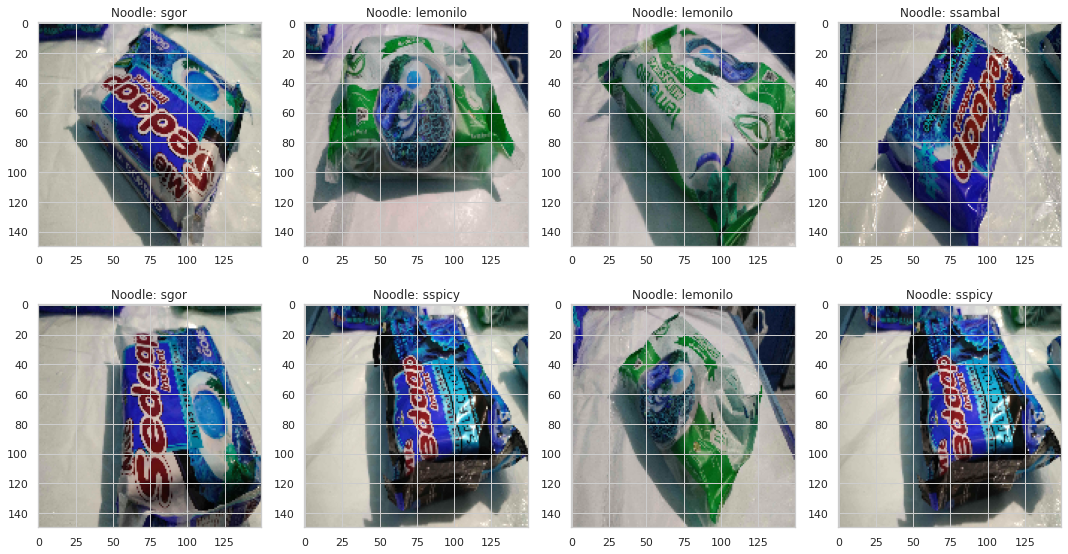

In [10]:
fig,ax = plt.subplots(2, 4)
fig.set_size_inches(15, 8)
for i in range(2):
    for j in range(4):
        l = rn.randint(0,len(Z))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Noodle: '+Z[l])
        
plt.tight_layout()

## 2.3. Label Encoding the Y array (i.e. lemonilo->0, sedaap-goreng->1 etc...) & then One Hot Encoding

In [11]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, 5)
X = np.array(X)
X = X/255

## 2.4. Splitting into Training and Validation Sets

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 42)

## 2.5. Setting the Random Seeds

In [13]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

# 3. Modelling
## 3.1. Building the ConvNet Model

In [14]:
# modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) 

model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation="softmax"))

## 3.2. Using a LR Annealer

In [15]:
batch_size  = 5
epochs = 80

from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.1)

## 3.3. Data Augmentation to prevent Overfitting

In [16]:
datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
                             samplewise_center=False,  # set each sample mean to 0
                             featurewise_std_normalization=False,  # divide inputs by std of the dataset
                             samplewise_std_normalization=False,  # divide each input by its std
                             zca_whitening=False,  # apply ZCA whitening
                             rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                             zoom_range=0.1, # Randomly zoom image 
                             width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width
                             height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

## 3.4. Compiling the Keras Model & Summary

In [17]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 96)        8

## 3.5. Fitting on the Training set and making predictions on the Validation set

In [18]:
History = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              epochs=epochs, validation_data=(x_test, y_test),
                              verbose=1, steps_per_epoch=x_train.shape[0] // batch_size)
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))

Epoch 1/80
8/8 [==============================] - 5s 145ms/step - loss: 1.6860 - accuracy: 0.1866 - val_loss: 1.5739 - val_accuracy: 0.1429
Epoch 2/80
8/8 [==============================] - 0s 38ms/step - loss: 1.5130 - accuracy: 0.2554 - val_loss: 1.5193 - val_accuracy: 0.1429
Epoch 3/80
8/8 [==============================] - 0s 35ms/step - loss: 1.3734 - accuracy: 0.3332 - val_loss: 1.5036 - val_accuracy: 0.2143
Epoch 4/80
8/8 [==============================] - 0s 37ms/step - loss: 1.4302 - accuracy: 0.2071 - val_loss: 1.4733 - val_accuracy: 0.2143
Epoch 5/80
8/8 [==============================] - 0s 35ms/step - loss: 1.3267 - accuracy: 0.3882 - val_loss: 1.4519 - val_accuracy: 0.1429
Epoch 6/80
8/8 [==============================] - 0s 35ms/step - loss: 1.2879 - accuracy: 0.3545 - val_loss: 1.5043 - val_accuracy: 0.2143
Epoch 7/80
8/8 [==============================] - 0s 37ms/step - loss: 1.1697 - accuracy: 0.5343 - val_loss: 1.1875 - val_accuracy: 0.3571
Epoch 8/80
8/8 [==========

# 4. Evaluating the Model Performance

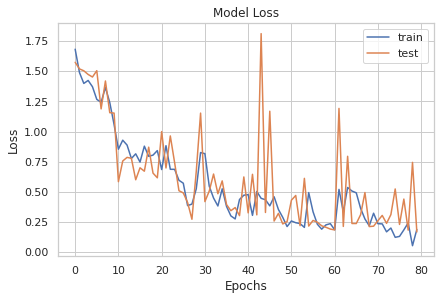

In [19]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

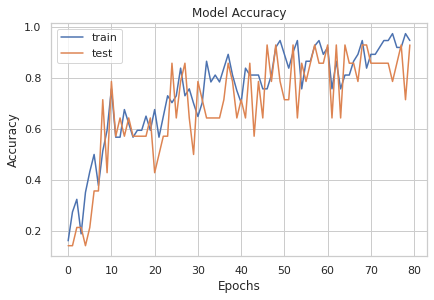

In [20]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# 5. Visualizing Predictons on the Validation Set

In [21]:
# getting predictions on val set.
pred = model.predict(x_test)
pred_digits = np.argmax(pred, axis=1)

In [22]:
# now storing some properly as well as misclassified indexes'.
i = 0
prop_class = []
mis_class = []

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i = 0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

## 5.1. Correct Classified Instant Noodles Images

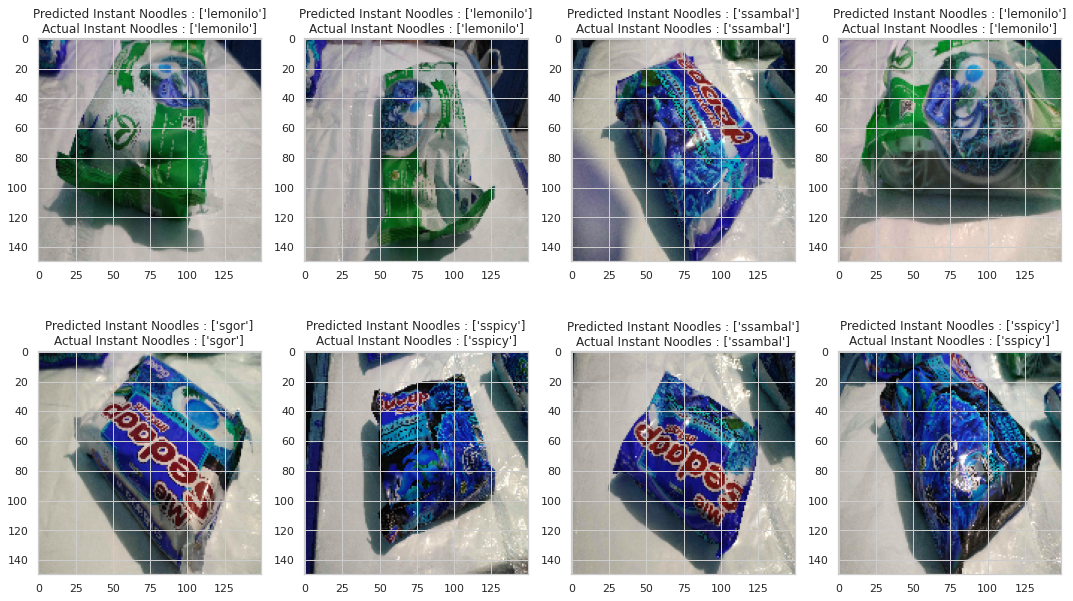

In [25]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count = 0
fig,ax = plt.subplots(2, 4)
fig.set_size_inches(15, 10)
for i in range(2):
    for j in range(4):
        ax[i, j].imshow(x_test[prop_class[count]])
        ax[i, j].set_title("Predicted Instant Noodles : "+str(le.inverse_transform([pred_digits[prop_class[count]]])) + "\n"
                           + "Actual Instant Noodles : "+str(le.inverse_transform([np.argmax(y_test[prop_class[count]])])))
        plt.tight_layout()
        count+=1

## 5.2. Wrong Classified Instant Noodles Images

IndexError: list index out of range

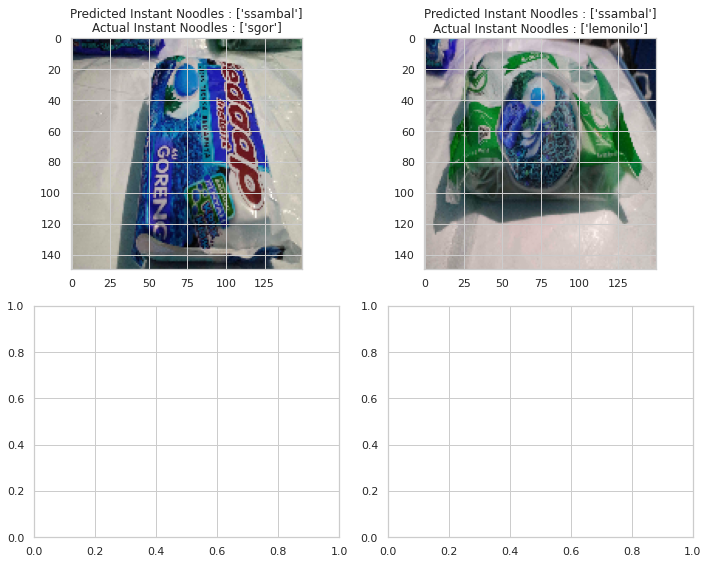

In [26]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count = 0
fig,ax = plt.subplots(2, 2)
fig.set_size_inches(10, 8)
for i in range(2):
    for j in range(2):
        ax[i, j].imshow(x_test[mis_class[count]])
        ax[i, j].set_title("Predicted Instant Noodles : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"
                           + "Actual Instant Noodles : "+str(le.inverse_transform([np.argmax(y_test[mis_class[count]])])))
        plt.tight_layout()
        count+=1

Reference

https://www.kaggle.com/rajmehra03/flower-recognition-cnn-keras